In [4]:
import numpy as np
import pandas as pd
import math
import torch

from joblib import dump, load
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.datasets import CIFAR10, GTSRB, MNIST, FashionMNIST, CIFAR100, ImageFolder, SVHN
import torchvision.transforms as transforms
from sklearn import metrics
from PIL import Image
from IPython.display import clear_output

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
%matplotlib inline

from methods_collection.utils.metrics_utils import auc_and_fpr_recall, acc
from methods_collection.mds.RuntimeMonitor import MdsMonitor
from networks import GtsrbAnnModel, MnistAnnModel, Cifar10AnnModel, ResNet18_32x32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
config = {}
config['resnet'] = {'noise': 0.001, 'threshold': -220}
config['cifar10'] = {'noise': 0.01, 'threshold': -45}
config['gtsrb'] = {'noise': 0.002, 'threshold': -90}

## Aux functions

In [7]:
class Convert:
    def __init__(self, mode='RGB'):
        self.mode = mode

    def __call__(self, image):
        return image.convert(self.mode)

In [8]:
def plot_roc_curve(true_y, y_prob):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [9]:
def compute_all_metrics(result_in, result_out, odin_th):
  conf_in, pred_in, lab_in = result_in
  conf_out, pred_out, lab_out = result_out
  lab_out = -1 * np.ones_like(lab_out)

  conf = np.concatenate([conf_in, conf_out])
  y_pred = np.concatenate([pred_in, pred_out])
  y_true = np.concatenate([lab_in, lab_out])

  recall = 0.95
  auroc, aupr_in, aupr_out, fpr = auc_and_fpr_recall(conf, y_true, recall)

  accuracy = acc(y_pred, y_true)

  lab_true = np.zeros_like(y_true)
  lab_true[y_true == -1] = 1
  lab_pred = np.zeros_like(y_true)
  lab_pred[conf<=odin_th] = 1

  tn, fp, fn, tp = confusion_matrix(lab_true, lab_pred).ravel()
  results = [np.round(auroc*100, 2), np.round(fpr*100, 2), np.round(aupr_out*100, 2), tn, fp, fn, tp]
  return results

In [10]:
def evaluate_ood(model, ood_monitor, dataset_name, train=False):
  batch_size = 128
  dataset, test_dataset, _ = load_dataset(dataset_name)

  set_loader = DataLoader(dataset, batch_size, num_workers=2) if train else DataLoader(test_dataset, batch_size, num_workers=2)

  all_pred = []
  all_conf = []
  all_lab = []
  valCorrect = 0
  for data, target in set_loader:
        (x, y) = (data.to(device), target.to(device))
        x.requires_grad = True
        pred_values, conf = ood_monitor.process_input(model, x)

        valCorrect += torch.sum(pred_values == y).cpu()

        all_pred += pred_values.detach().cpu().numpy().tolist()
        all_conf += conf.detach().cpu().numpy().tolist()
        all_lab += y.detach().cpu().numpy().tolist()
  all_conf = np.array(all_conf)
  all_pred = np.array(all_pred)
  all_lab = np.array(all_lab)

  print(f'Accuracy: {np.round(valCorrect * 100 / len(set_loader.dataset), 2)}')

  return all_conf, all_pred, all_lab

In [11]:
def evaluate_ood_gaussian(model, ood_monitor, dataset_name, data_size=10000):
  dataset, test_dataset, transform = load_dataset(dataset_name)
  batch_size = 100
  num_batches = int(data_size/batch_size)

  all_conf = []
  all_pred = []
  all_lab = []
  for i in range(num_batches):
    np_images = np.asarray(np.uint8(np.random.rand(batch_size, 32, 32, 3) * 255))
    pil_images_tr = [transform(Image.fromarray(im, 'RGB')) for im in np_images]
    gaussian_noise = torch.stack(pil_images_tr).to(device)
    gaussian_noise.requires_grad = True
    pred_values, conf = ood_monitor.process_input(model, gaussian_noise)
    all_pred += pred_values.detach().cpu().numpy().tolist()
    all_conf += conf.detach().cpu().numpy().tolist()
    all_lab += -1 * np.ones(data_size).tolist()


  all_conf = np.array(all_conf)
  all_pred = np.array(all_pred)
  all_lab = np.array(all_lab)

  return all_conf, all_pred, all_lab

# CIFAR10 model evaluation

## Dataset loading

In [24]:
def load_dataset(DATASET_TO_USE):
  dataset = None
  test_dataset = None
  transform = transforms.Compose([
      Convert('RGB'),
      transforms.Resize([32, 32], interpolation=transforms.InterpolationMode.BILINEAR),
      transforms.CenterCrop(32),
      transforms.ToTensor(),
      #transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
      ])
  if DATASET_TO_USE == 'CIFAR10':
    root_dataset_path = './datasets/cifar10/'
    dataset = CIFAR10(root=root_dataset_path, download=False, transform=transform)
    test_dataset = CIFAR10(root=root_dataset_path, train=False, transform=transform)
  if DATASET_TO_USE == 'GTSRB':
    root_dataset_path = './datasets/'
    dataset = GTSRB(root='./datasets/', download=False, split='train', transform=transform)
    test_dataset = GTSRB(root='./datasets/', download=False, split='test',transform=transform)
  if DATASET_TO_USE == 'MNIST':
    root_dataset_path = './datasets/mnist/'
    dataset = MNIST(root=root_dataset_path, download=False, transform=transform)
    test_dataset = MNIST(root=root_dataset_path, train=False, transform=transform)
  if DATASET_TO_USE == 'FashionMNIST':
    root_dataset_path = './datasets/fashion_mnist/'
    dataset = FashionMNIST(root=root_dataset_path, train=True, download=False, transform=transform)
    test_dataset = FashionMNIST(root=root_dataset_path, train=False, download=False, transform=transform)
  if DATASET_TO_USE == 'CIFAR100':
    root_dataset_path = './datasets/cifar100/'
    dataset = CIFAR100(root=root_dataset_path, download=True, transform=transform)
    test_dataset = CIFAR100(root=root_dataset_path, train=False, transform=transform)
  if DATASET_TO_USE == 'IMAGENET':
    dataset = ImageFolder(root='./datasets/Imagenet_resize/',  transform=transform)
    test_dataset = ImageFolder(root='./datasets/Imagenet_resize/',  transform=transform)
  if DATASET_TO_USE == 'SVHN':
    root_dataset_path = './datasets/svhn/'
    dataset = SVHN(root=root_dataset_path, split='train', download=True, transform=transform)
    test_dataset = SVHN(root=root_dataset_path, split='test', download=True, transform=transform)

  return dataset, test_dataset, transform

## Model loading

In [13]:
cifar10_model = Cifar10AnnModel().to(device)
cifar10_model.load_state_dict(torch.load('./models/cifar_10_ann_model/model/model.pth'))
cifar10_model.eval()

resnet = ResNet18_32x32(num_classes=10).to(device)
resnet.load_state_dict(
    torch.load('./models/cifar10_resnet18_32x32_base_e100_lr0.1_default/s0/best.ckpt', map_location=torch.device('cpu'))
)
resnet.eval()

gtsrb_model = GtsrbAnnModel().to(device)
gtsrb_model.load_state_dict(torch.load('./models/gtsrb_ann_model/model/model.pth'))
gtsrb_model.eval()

GtsrbAnnModel(
  (conv_net): Sequential(
    (0): Conv2d(3, 40, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(40, 20, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (linear1): Linear(in_features=500, out_features=240, bias=True)
  (batchnorm1): LayerNorm((240,), eps=1e-05, elementwise_affine=True)
  (activation1): ReLU()
  (linear2): Linear(in_features=240, out_features=84, bias=True)
  (batchnorm2): LayerNorm((84,), eps=1e-05, elementwise_affine=True)
  (activation2): ReLU()
  (linear3): Linear(in_features=84, out_features=43, bias=True)
  (activation3): Softmax(dim=1)
)

## Monitor tuning

In [ ]:
dataset, test_dataset, transform = load_dataset('GTSRB')
batch_size = 128
train_loader = DataLoader(dataset, batch_size, num_workers=2)

cifar10_mds_monitor = MdsMonitor(0.0, 43, ['mean','mean', 'mean'], ['none', 'none', 'none'], device)
cifar10_mds_monitor.alpha_list = [0, 0, 1]
cifar10_mds_monitor.setup(gtsrb_model, train_loader)

In [ ]:
# search grid for noise value used in mahalanobis paper's code
noise_values = [0.0, 0.0005, 0.001, 0.0014, 0.002, 0.0024, 0.005, 0.01, 0.05, 0.1, 0.2]
#noise_values = [0.3, 0.4, 0.5, 0.52, 0.55, 0.57, 0.6]

noise_values = list(set(noise_values))
noise_values.sort()

best_auroc = None
best_temperature_value = None
best_noise_value = None
default_noise = 0.0
default_auroc = None

for noise in noise_values:
  print(f'Evaluating noise: {noise}')
  cifar10_mds_monitor.magnitude = noise
  all_conf_in, all_pred, _ = evaluate_ood(gtsrb_model, cifar10_mds_monitor, 'GTSRB', True)
  y_in = np.zeros(all_conf_in.shape)

  all_conf_out, all_pred_out, _ = evaluate_ood_gaussian(gtsrb_model, cifar10_mds_monitor, 'GTSRB', 39000)
  y_out = np.ones(all_conf_out.shape)

  all_conf = np.concatenate((all_conf_in, all_conf_out), axis=None)
  y = np.concatenate((y_in, y_out), axis=None)

  auroc = roc_auc_score(y_true = y, y_score = all_conf)
  if best_auroc is None or auroc < best_auroc:
      best_noise_value = noise
      best_auroc = auroc

  print(auroc)
  print('--------------')
print(best_noise_value)
cifar10_mds_monitor.magnitude = best_noise_value

Evaluating noise: 0.0
Accuracy: 97.55000305175781
0.008493548380768151
--------------
Evaluating noise: 0.0005
Accuracy: 97.55000305175781
0.0075422508960854735
--------------
Evaluating noise: 0.001
Accuracy: 97.55000305175781
0.007141100519176982
--------------
Evaluating noise: 0.0014
Accuracy: 97.55000305175781
0.00704098843083515
--------------
Evaluating noise: 0.002
Accuracy: 97.55000305175781
0.007028996155382954
--------------
Evaluating noise: 0.0024
Accuracy: 97.55000305175781
0.007346020765771336
--------------
Evaluating noise: 0.005
Accuracy: 97.55000305175781
0.009689787339510616
--------------
Evaluating noise: 0.01
Accuracy: 97.55000305175781
0.030992693331136037
--------------
Evaluating noise: 0.05
Accuracy: 97.55000305175781
0.24298097179415246
--------------
Evaluating noise: 0.1
Accuracy: 97.55000305175781
0.3565490000660497
--------------
Evaluating noise: 0.2
Accuracy: 97.55000305175781
0.4673692918488756
--------------
0.002


In [ ]:
print(best_noise_value)
dataset, test_dataset, transform = load_dataset('GTSRB')
batch_size = 128
train_loader = DataLoader(dataset, batch_size, num_workers=2)
config['gtsrb']['noise'] = 0.002
cifar10_mds_monitor = MdsMonitor(config['gtsrb']['noise'], 43, ['mean','mean', 'mean'], ['none', 'none', 'none'], device)
cifar10_mds_monitor.alpha_list = [0, 0, 1]
cifar10_mds_monitor.setup(gtsrb_model, train_loader)

0.002


In [ ]:
all_conf_in, all_pred_in, _ = evaluate_ood(gtsrb_model, cifar10_mds_monitor, 'GTSRB', True)

Accuracy: 97.55000305175781


37360


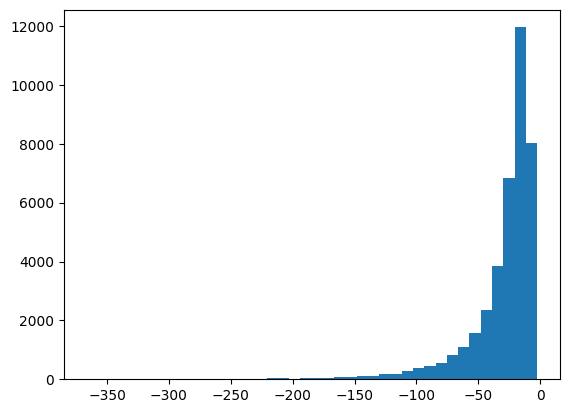

In [ ]:
config['gtsrb']['threshold'] = -90
print(np.sum(all_conf_in>config['gtsrb']['threshold']))
plt.hist(all_conf_in, bins = 40)
plt.show()

In [ ]:
all_conf_out, all_pred_out, _ = evaluate_ood_gaussian(gtsrb_model, cifar10_mds_monitor, 'GTSRB', 39000)

38464


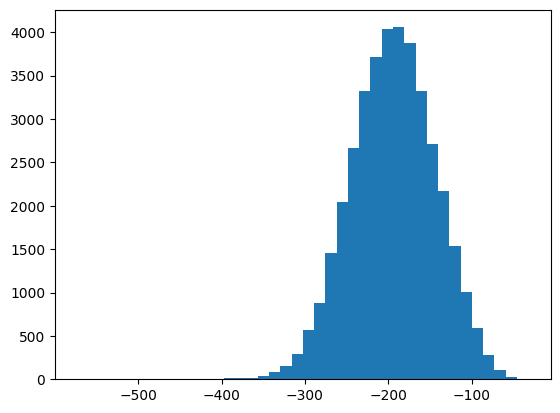

In [ ]:
print(np.sum(all_conf_out<=config['gtsrb']['threshold']))
plt.hist(all_conf_out, bins = 40)
plt.show()

## Evaluation

ResNet

In [16]:
dataset, test_dataset, transform = load_dataset('CIFAR10')
batch_size = 128
train_loader = DataLoader(dataset, batch_size, num_workers=2)

results_resnet = {}
resnet_mds_monitor = MdsMonitor(config['resnet']['noise'], 10, ['mean','mean', 'mean', 'mean', 'mean'], ['none', 'none', 'none', 'none', 'none'], device)
resnet_mds_monitor.alpha_list = [0, 0, 0, 0, 1]
resnet_mds_monitor.setup(resnet, train_loader)

/content/BNN_monitor/methods_collection/mds/RuntimeMonitor/mds_utils.py:144: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  feature_mean_list = [torch.Tensor(i).to(device) for i in feature_mean_list]


In [ ]:
results_resnet['in'] = evaluate_ood(resnet, resnet_mds_monitor, 'CIFAR10')
results_resnet['out_cifar100'] = evaluate_ood(resnet, resnet_mds_monitor, 'CIFAR100')
results_resnet['out_image_net'] = evaluate_ood(resnet, resnet_mds_monitor, 'IMAGENET')
results_resnet['out_svhn'] = evaluate_ood(resnet, resnet_mds_monitor, 'SVHN')

In [18]:
result1 = compute_all_metrics(results_resnet['in'], results_resnet['out_cifar100'], config['resnet']['threshold'])
result2 = compute_all_metrics(results_resnet['in'], results_resnet['out_image_net'], config['resnet']['threshold'])
result3 = compute_all_metrics(results_resnet['in'], results_resnet['out_svhn'], config['resnet']['threshold'])

print(['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp'])
result1_string = ''
for r in result1:
 result1_string += '$'+str(r)+'$' + " & "
print(result1_string)

result2_string = ''
for r in result2:
 result2_string +='$'+str(r)+'$' + " & "
print(result2_string)

result3_string = ''
for r in result3:
 result3_string += '$'+str(r)+'$' + " & "
print(result3_string)

['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp']
$84.82$ & $54.9$ & $83.02$ & $4827$ & $5173$ & $583$ & $9417$ & 
$92.84$ & $26.81$ & $91.47$ & $4827$ & $5173$ & $100$ & $9900$ & 
$92.79$ & $22.2$ & $95.59$ & $4827$ & $5173$ & $140$ & $25892$ & 


Cifar10AnnModel

In [20]:
dataset, test_dataset, transform = load_dataset('CIFAR10')
batch_size = 128
train_loader = DataLoader(dataset, batch_size, num_workers=2)

results_cifar10 = {}
cifar10_mds_monitor = MdsMonitor(config['cifar10']['noise'], 10, ['mean','mean', 'mean'], ['none', 'none', 'none'], device)
cifar10_mds_monitor.alpha_list = [0, 0, 1]
cifar10_mds_monitor.setup(cifar10_model, train_loader)

In [21]:
results_cifar10['in'] = evaluate_ood(cifar10_model, cifar10_mds_monitor, 'CIFAR10')
results_cifar10['out_cifar100'] = evaluate_ood(cifar10_model, cifar10_mds_monitor, 'CIFAR100')
results_cifar10['out_image_net'] = evaluate_ood(cifar10_model, cifar10_mds_monitor, 'IMAGENET')
results_cifar10['out_svhn'] = evaluate_ood(cifar10_model, cifar10_mds_monitor, 'SVHN')

Accuracy: 70.19999694824219
Files already downloaded and verified
Accuracy: 1.0299999713897705
Accuracy: 8.149999618530273
Using downloaded and verified file: ./datasets/svhn/train_32x32.mat
Using downloaded and verified file: ./datasets/svhn/test_32x32.mat
Accuracy: 11.210000038146973


In [22]:
result1 = compute_all_metrics(results_cifar10['in'], results_cifar10['out_cifar100'], config['cifar10']['threshold'])
result2 = compute_all_metrics(results_cifar10['in'], results_cifar10['out_image_net'], config['cifar10']['threshold'])
result3 = compute_all_metrics(results_cifar10['in'], results_cifar10['out_svhn'], config['cifar10']['threshold'])

print(['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp'])
result1_string = ''
for r in result1:
 result1_string += '$'+str(r)+'$' + " & "
print(result1_string)

result2_string = ''
for r in result2:
 result2_string += '$'+str(r)+'$' + " & "
print(result2_string)

result3_string = ''
for r in result3:
 result3_string += '$'+str(r)+'$' + " & "
print(result3_string)

['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp']
$65.06$ & $85.17$ & $62.16$ & $7617$ & $2383$ & $5749$ & $4251$ & 
$72.03$ & $79.75$ & $70.54$ & $7617$ & $2383$ & $4485$ & $5515$ & 
$52.78$ & $86.23$ & $70.51$ & $7617$ & $2383$ & $21312$ & $4720$ & 


GtsrbAnnModel

In [25]:
dataset, test_dataset, transform = load_dataset('GTSRB')
batch_size = 128
train_loader = DataLoader(dataset, batch_size, num_workers=2)

results_gtsrb = {}
gtsrb_mds_monitor = MdsMonitor(config['gtsrb']['noise'], 43, ['mean','mean', 'mean'], ['none', 'none', 'none'], device)
gtsrb_mds_monitor.alpha_list = [0, 0, 1]
gtsrb_mds_monitor.setup(gtsrb_model, train_loader)

In [26]:
results_gtsrb['in'] = evaluate_ood(gtsrb_model, gtsrb_mds_monitor, 'GTSRB')
results_gtsrb['out_cifar100'] = evaluate_ood(gtsrb_model, gtsrb_mds_monitor, 'CIFAR100')
results_gtsrb['out_image_net'] = evaluate_ood(gtsrb_model, gtsrb_mds_monitor, 'IMAGENET')
results_gtsrb['out_svhn'] = evaluate_ood(gtsrb_model, gtsrb_mds_monitor, 'SVHN')

Accuracy: 91.63999938964844
Files already downloaded and verified
Accuracy: 0.9200000166893005
Accuracy: 1.590000033378601
Using downloaded and verified file: ./datasets/svhn/train_32x32.mat
Using downloaded and verified file: ./datasets/svhn/test_32x32.mat
Accuracy: 1.2200000286102295


In [27]:
result1 = compute_all_metrics(results_gtsrb['in'], results_gtsrb['out_cifar100'], config['gtsrb']['threshold'])
result2 = compute_all_metrics(results_gtsrb['in'], results_gtsrb['out_image_net'], config['gtsrb']['threshold'])
result3 = compute_all_metrics(results_gtsrb['in'], results_gtsrb['out_svhn'], config['gtsrb']['threshold'])

print(['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp'])
result1_string = ''
for r in result1:
 result1_string += '$'+str(r)+'$' + " & "
print(result1_string)

result2_string = ''
for r in result2:
 result2_string += '$'+str(r)+'$' + " & "
print(result2_string)

result3_string = ''
for r in result3:
 result3_string += '$'+str(r)+'$' + " & "
print(result3_string)

['auroc', 'fpr', 'aupr_out', 'tn', 'fp', 'fn', 'tp']
$98.08$ & $7.8$ & $96.89$ & $11403$ & $1227$ & $287$ & $9713$ & 
$98.41$ & $6.75$ & $97.44$ & $11403$ & $1227$ & $207$ & $9793$ & 
$97.29$ & $10.17$ & $98.14$ & $11403$ & $1227$ & $1423$ & $24609$ & 
